In [1]:
#simply we loaded the images from our data base.
#-----------------------------------------------#

import cv2                 # we use this library to resizing, images
import numpy as np         # used for dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # For Percentage bar's which are shown the code.

TRAIN_DIR = 'train'     #data
TEST_DIR = 'test'       #data
IMG_SIZE = 50
LR = 1e-3                  # learning Rate = 0.001

uzair_model = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic-video') # For our memory which saved model is which.

In [2]:
#Here we defined a funtion to label the Images.
#-----------------------------------------------#

def label_img(img):
    word_label = img.split('.')[-3]
   
    if word_label == 'cat': return [1,0]
    
    elif word_label == 'dog': return [0,1]

In [3]:
#Here we defined a funtion to create train data.
#-----------------------------------------------#

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
#Here we defined a funtion to create test data.
#-----------------------------------------------#


def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()
test_data = process_test_data()

100%|██████████| 12500/12500 [00:24<00:00, 506.07it/s]


In [1]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [7]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(uzair_model)):
    model.load(uzair_model)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=uzair_model)
model.save(uzair_model)

Training Step: 19149  | total loss: 0.05086 | time: 525.730s
| Adam | epoch: 050 | loss: 0.05086 - acc: 0.9819 -- iter: 24448/24500
Training Step: 19150  | total loss: 0.04942 | time: 528.085s
| Adam | epoch: 050 | loss: 0.04942 - acc: 0.9821 | val_loss: 1.64589 - val_acc: 0.7520 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\uzair.aslam\dogsvscats-0.001-2conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


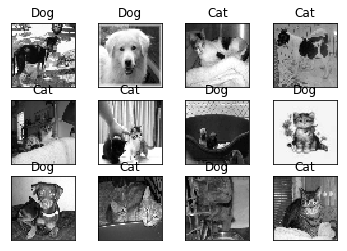

In [9]:
import matplotlib.pyplot as plt

test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [31]:
#For the plots and Graphs

#tensorboard --logdir=foo:C:\Users\uzair.aslam\log
#http://NB-UASLAM:6006

In [10]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:24<00:00, 515.03it/s]
